# Synthetic surface classification 
In this notebook we show how to integrate $2$- forms in $\mathbb{R}^n$ over the $2$-simplices of a complex and use this method to classify surfaces in $\mathbb{R}^3$

# Final example notebook 

### Theory 

A $2$-form in $\mathbb{R}^n$, denoted by $\omega \in \Omega^2(\mathbb{R}^n)$ can be written as $$\omega = \sum_{1\leq i < j \leq n} f_{i,j} dx_i\wedge dx_j$$
where $f_{i,j}: \mathbb{R}^n\longrightarrow \mathbb{R}^N$, with $N = \binom{n}{2} $ are smooth maps. 

**remark 1:** this means that we can train a neural network $\mathbb{R}^n \longrightarrow \mathbb{R}^N$ to learn $2$-forms on $\mathbb{R}^n$.

##### Integrating a $2$-form on a 2-simplex:
Denote by $\Delta$ the standard $2$-simplex in $\mathbb{R}^2$ with vertices $(0,0), (1,0), (0,1)$.
A $2$-simplex $\sigma$ in $\mathbb{R}^n$ is obtained as the embedding of $\Delta$ via a map $\varphi: \Delta \longrightarrow \mathbb{R}^n$, $\sigma = \varphi(\Delta)$. Thus to integrate the $2$-form $\omega$ on $\sigma$ one can use the identity: 
$$ \int_{\varphi(\Delta)}\omega = \int_{\Delta}\varphi^{*}\omega$$

To obtain a $2$-cochain on an embedded simplicial complex, one integrates the $2$-form on each $2$-simplex. 


**remark 2:** In more generality one can learn any $k$-form on $\mathbb{R}^n$ and integrate it on a $k$-simplex.   

### Algorithmically : 

To compute the integral on a simplex one must make an approximation in the following way. 
1. subdivide $\Delta$ into $m^2$ $2$-simplices $\mathcal{S} = \{s_l\}_{0\leq l \leq m^2}$ of equal area 
2. Denote by $V$ the set of vertices in the subdivision of $\Delta$
3. For any $p\in \Delta$ one can evaluate $\omega$ at that point and get a map $g: \Delta \rightarrow \mathbb{R}$ in the following way:
$$ g(p) = \sum_{i<j} f_{i,j}(\varphi(p))dx_i\wedge dx_j (\varphi_{*}\frac{\partial}{\partial y_1}\mid_p,\varphi_{*}\frac{\partial}{\partial y_2}\mid_p)$$
4. In particular to approximate the contribution of a $2$-simplex $s\in\mathcal{S}$ to the integral one averages the value of $g(p)$ on each of its vertices $p$. Overall each vertex will contribute with weight
    - 1 if $p\in\{(0,0),(1,0),(0,1)\}$
    - 3 if $p$ is in the interior of an edge of $\Delta$
    - 6 if $p$ is in the interior of $\Delta$

    to the approximating sum below : 
5. By reordering the terms we get the following expression for the integral 
$$ \int_{\varphi(\Delta)} \omega = \frac{1}{m^2} \sum_{p\in V} |cof(p)|\cdot g(p) \cdot vol(\varphi(\Delta))$$ 


To compute $$dx_i\wedge dx_j (\varphi_{*}\frac{\partial}{\partial y_1}\mid_p,\varphi_{*}\frac{\partial}{\partial y_2}\mid_p)$$
one does the following: 


<span style="color: red;">  FILLLL </span>


In [54]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import math
import gudhi as gd 
import scipy.special
import neural_kforms as kf
import k_forms_visual as vis 
import pickle
import torch.optim as optim
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Generate the data  

##### We generate synthetic surfaces by embedding a triangulated unit square in $\mathbb{R}^3$. First we build the underlying simplicial complex. 

there are 32 2-simplices in the triangulation


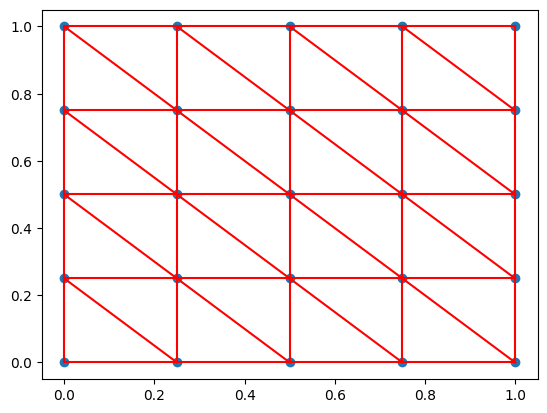

In [37]:
num_pts = 5
# Triangulate the unit square 
pts , ac = kf.plot_unit_square_grid(num_pts)
simplices = []

## retain only the 2-simplices in a list
for s in ac.get_skeleton(2):
    if len(s[0]) == 3: 
        simplices.append(s[0])
print("there are {} 2-simplices in the triangulation".format(len(simplices)))

##### Then we randomly generate surfaces in $\mathbb{R}^3$ in two different classes. 

In [38]:
num_surf = 30

s0 = kf.generate_surfaces_sin_x(num_surf, num_pts)
s1 = kf.generate_surfaces_sin_y(num_surf, num_pts)

surfaces = s0 + s1 

# generate labels
labels = np.concatenate((np.zeros(num_surf),np.ones(num_surf)))

# perform a one hot encoding of the labels and transform to torch
labels_one_hot = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

## shuffle the data and the labels in the same way
shuffled_indices = torch.randperm(len(surfaces)) 
surfaces_shuffled = [surfaces[i] for i in shuffled_indices]
labels_one_hot_shuffled = labels_one_hot[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

print( "There are {} surfaces in the data set".format(len(surfaces_shuffled)))

There are 60 surfaces in the data set


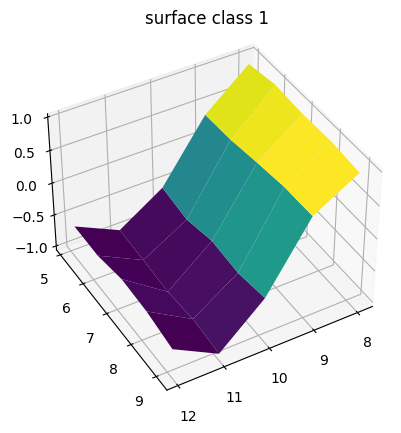

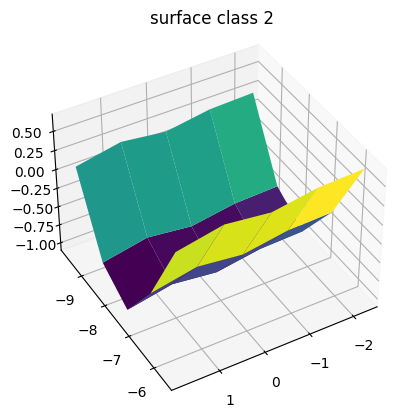

In [39]:
# plot example of surfaces from each class
X1,Y1,Z1,_ = s0[0]
X2,Y2,Z2,_ = s1[0]
vis.plot_surface(X1,Y1,Z1, title = 'surface class 1')
vis.plot_surface(X2,Y2,Z2, title = 'surface class 2')

##### Reformating each surface into a dictionary for easier use later: 
- `'simplices'` contains the 2-simplices of the underlying abstract simplicial complex 
- `'Phi'` contains the linear part of the embedding for each 2-simplex
- `'b'` contains the affine part of the embedding for each 2-simplex
- `'points'` contains an array of the coordinates of the vertices in $\mathbb{R}^3$

In [40]:
## making dictionaries out of the surfaces
surfaces_list = []
for surf in range(num_surf*2): 
    surface = surfaces[surf]
    surface_dict= {}
    surface_dict['simplices'] = simplices

    translation = torch.tensor(np.random.uniform(-10, 10, 3))
    
    surface_dict['points'] = surface[3]
    surface_dict['Phi'] = []
    surface_dict['b'] = []
    

    for i in range(len(surface_dict['simplices'])):
        s = surface_dict['simplices'][i]
        emb_vertices_simplex = surface_dict['points'][s]
        phi_simplex, b_simplex = kf.phi_b(emb_vertices_simplex )
        surface_dict['Phi'].append(phi_simplex)
        surface_dict['b'].append(b_simplex)

    surfaces_list.append(surface_dict)

surfaces_list_shuffled = [surfaces_list[i] for i in shuffled_indices]

# 2. Classification 

In [41]:
k = 2 # degree of the k-forms
dim = 3 # dimension of the embedding space

# some things to precompute for integration 
det = kf.build_determinant_tensor(dim, k) # tensor needed for a step in integration of 2-forms

num_sub = 2 # number of subdivision of each 2-simplex for approximating the integral of the 2-forms
vertices, coefs = kf.subdivide_simplex_coef_torch(num_sub) 

##### We learn two 2-forms in $\mathbb{\R}^3$. Recall that a 2-form can be written as $$\omega = \sum_{1\leq i < j \leq n} f_{i,j} dx_i\wedge dx_j$$ where $f_{i,j}: \mathbb{R}^n\longrightarrow \mathbb{R}^N$ are smooth maps and $N = \binom{n}{2}$. This means that we can train a neural network with input layer of size $n$ and final layer of size $N$ to learn a 2-form. To learn $l$ 2-forms we can train a neural network with final layer of size $N\cdot l$.

In [42]:
classes = 2
num_kforms = 2 ## number of k-forms to learn 
N = int(scipy.special.binom(dim,k)) 

# MLP to learn 2-forms 
kforms = nn.Sequential(
    nn.Linear(dim, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, N*num_kforms)
)

#### Train the MLP above and integrate its output to obtain cochains on the simplicial complexes (surfaces embedded in $\mathbb{R}^3$). The obtained cochains classify the surfaces into two classes

In [43]:
epochs = 4

lr = 1e-1 # learning rate 

optimizer = optim.SGD(kforms.parameters(), lr) 

criterion = nn.CrossEntropyLoss()

losses = torch.zeros(epochs)

labels_one_hot_shuffled = labels_one_hot_shuffled.to(torch.float32)

torch.autograd.set_detect_anomaly(True)

Accuracies = []
Losses= []

for e in range(epochs):
    print('epoch: ', e)
    
    correct = 0
    total = 0

    for i in range(len(surfaces_list_shuffled)):
        surface_dict= surfaces_list_shuffled[i]
        l = labels_one_hot_shuffled[i]
        
        X = kf.forms2cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_kforms, dim, k) ## integrate the learned 2-forms to obtain cochains on the simplicial complex 
        X = torch.reshape(X, (len(surface_dict['simplices']), num_kforms))
        X.retain_grad() 
        X = X.sum(0)
        X.retain_grad()
    
        sm = torch.nn.functional.softmax(X)    # softmax classifier 
        loss = criterion(sm,l) 
        print("loss: ", loss)
        
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        
        pred = torch.argmax(torch.nn.functional.softmax(X))
        #print('pred: ', pred)
        #print('label: ', torch.argmax(l))
        if pred == torch.argmax(l):
            correct += 1
        total += 1
        #print('correct: ', correct)

        if i % 10 == 0:
            print("number of surfaces processed: ", i)

    print('Accuracy of the network on the {} training surfaces at epoch {} : {} '.format(num_surf*2, e, (100 * correct / total)))
    Accuracies.append(100 * correct / total)
    Losses.append(loss)

    print('-----------')
    print('***********')
    print('-----------')



epoch:  0


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss:  tensor(0.7602, grad_fn=<DivBackward1>)


/Users/celiahacker/opt/anaconda3/envs/celia/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


number of surfaces processed:  0
loss:  tensor(0.7683, grad_fn=<DivBackward1>)
loss:  tensor(0.7611, grad_fn=<DivBackward1>)
loss:  tensor(0.6697, grad_fn=<DivBackward1>)
loss:  tensor(0.6969, grad_fn=<DivBackward1>)
loss:  tensor(0.9756, grad_fn=<DivBackward1>)
loss:  tensor(0.6498, grad_fn=<DivBackward1>)
loss:  tensor(0.7248, grad_fn=<DivBackward1>)
loss:  tensor(0.6565, grad_fn=<DivBackward1>)
loss:  tensor(0.6970, grad_fn=<DivBackward1>)
loss:  tensor(0.8121, grad_fn=<DivBackward1>)
number of surfaces processed:  10
loss:  tensor(0.7109, grad_fn=<DivBackward1>)
loss:  tensor(0.7234, grad_fn=<DivBackward1>)
loss:  tensor(0.5847, grad_fn=<DivBackward1>)
loss:  tensor(0.8658, grad_fn=<DivBackward1>)
loss:  tensor(0.6770, grad_fn=<DivBackward1>)
loss:  tensor(0.5724, grad_fn=<DivBackward1>)
loss:  tensor(0.6487, grad_fn=<DivBackward1>)
loss:  tensor(0.7536, grad_fn=<DivBackward1>)
loss:  tensor(0.7650, grad_fn=<DivBackward1>)
loss:  tensor(0.5595, grad_fn=<DivBackward1>)
number of sur

# Plots

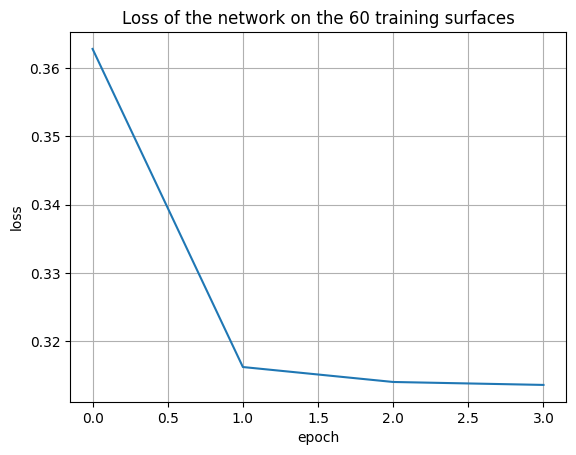

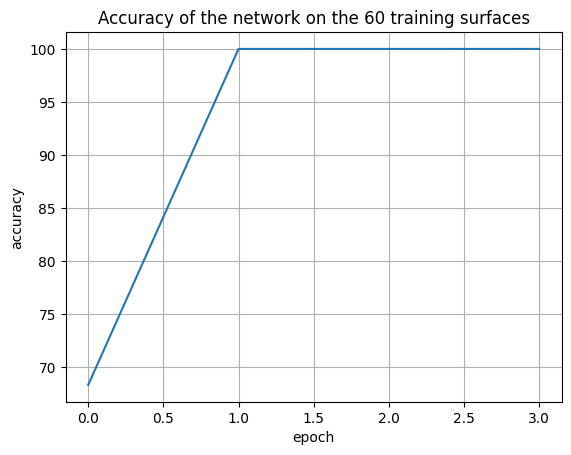

In [44]:
# plot the loss
Losses = [loss.detach() for loss in Losses]
fig, ax = plt.subplots()
ax.plot(np.arange(len(Losses)), Losses)
ax.set(xlabel='epoch', ylabel='loss', title='Loss of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

# plot the accuracy
fig, ax = plt.subplots()
ax.plot(np.arange(len(Accuracies)), Accuracies)
ax.set(xlabel='epoch', ylabel='accuracy', title='Accuracy of the network on the {} training surfaces'.format(num_surf*2))
ax.grid()
plt.show()

In [46]:
cochains = [] #cochains obtained from the final learned 2-forms 
for i in range(len(surfaces_list)):
    surface_dict= surfaces_list[i]
    cochain = kf.forms2cochains(kforms, surface_dict, det,vertices, coefs, num_sub, num_kforms, dim, k) ## multiple cochains 
    cochain = cochain.detach().numpy()
    cochains.append(cochain)


cochain0 = [cochains[i][:,0] for i in range(len(cochains))]
cochain1 = [cochains[i][:,1] for i in range(len(cochains))]

representation = np.zeros((num_surf*2, 2))
for i in range(200):
    representation[i,0] = np.sum(cochain0[i])
    representation[i,1] = np.sum(cochain1[i])

KeyboardInterrupt: 

In [48]:

representation = np.zeros((num_surf*2, 2))
for i in range(num_surf*2):
    representation[i,0] = np.sum(cochain0[i])
    representation[i,1] = np.sum(cochain1[i])


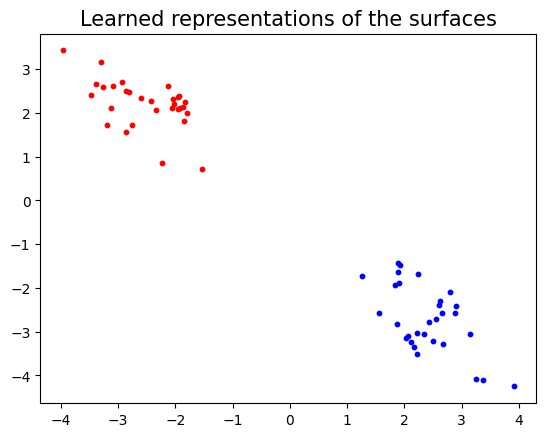

In [51]:
# plot the representation

fig, ax = plt.subplots()

for i in range(num_surf): 
    ax.scatter(representation[i,0], representation[i,1], s = 10, c='blue')
for i in range(num_surf,num_surf*2):
    ax.scatter(representation[i,0], representation[i,1], s = 10, c='red')

ax.set_title('Learned representations of the surfaces', size = 15)
plt.show()

# continue cleaning here 

-2.9975994
2.7284184
bla
-1.6884102
2.280055


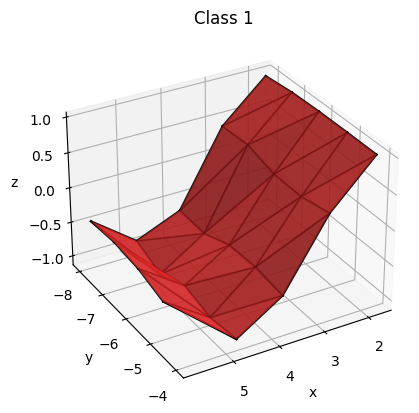

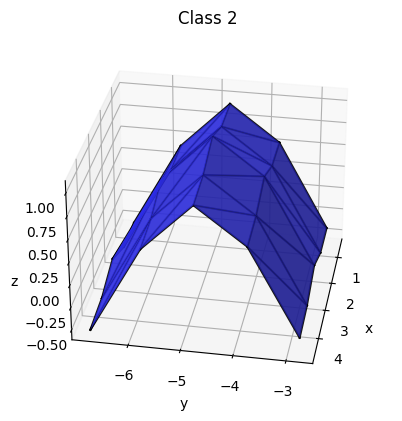

In [59]:
cochain_np= np.array(cochain1)
cochain_np = cochain_np.flatten()
min_val = cochain_np.min()
max_val = cochain_np.max()
print(min_val)
print(max_val)



edges = [] #list of 1-simplices
for s in ac.get_skeleton(2):
    if len(s[0]) == 2: 
        edges.append(s[0])


k = 1
view = (30,60)
surface = surfaces_list[k]
#color = vis.value2color_all(cochain1[k], min_val, max_val)
color = vis.value2color_all(representation[k,0], min_val, max_val)
vis.plot_surface_integral(surface, color, simplices, edges, num_pts, title = 'Class 1', view = view)
print('bla')
print(np.sum(cochain1[k]))



k = -1
view = (30,10)
surface = surfaces_list[k]
#color = vis.value2color_all(cochain1[k], min_val, max_val)
color = vis.value2color_all(representation[k,0], min_val, max_val)
vis.plot_surface_integral(surface, color, simplices, edges, num_pts, title = 'Class 2', view = view)
print(np.sum(cochain1[k]))